# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

## Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

# loading the teams data
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

In [3]:
matches.keys()

dict_keys(['Italy', 'England', 'Germany', 'France', 'Spain', 'European_Championship', 'World_Cup'])

### JSON to DataFrame

In [4]:
teams_df = pd.DataFrame(teams)
players_df = pd.DataFrame(players)
competitions_df = pd.DataFrame(competitions)
matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

## Italian first division

In [5]:
competitions_df

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


In [6]:
italian_teams_df = teams_df[(teams_df['area'].apply(lambda x: x.get('name')) == 'Italy') & (teams_df['type'] == 'club')]

In [7]:
teams_matches = {}
#prints the name and code of each team
for team in italian_teams_df.iterrows():
    teams_matches[team[1]['wyId']] = matches_df['Italy'][matches_df['Italy']['teamsData'].apply(lambda x: x.get(str(team[1]['wyId'])) != None)]
    teams_matches[team[1]['wyId']].sort_values(by='gameweek')

In [8]:
len(teams_matches.keys())

20

In [9]:
italian_events_df = events_df['Italy'][events_df['Italy']['playerId'] != 0]
italian_events_df = italian_events_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'])

In [10]:
distances = {}
for team in italian_teams_df.iterrows():
    distances[team[1]['wyId']] = {}

In [11]:
distance = 0
playerId = -1
position = (0,0)
teamId = -1
gameweek = 0
for event in italian_events_df.iterrows():
    if event[1]['playerId'] != playerId:
        if distance != 0 and playerId != -1:
            if playerId not in distances[teamId]:
                distances[teamId][playerId] = [[gameweek, distance]]
            else:
                distances[teamId][playerId].append([gameweek, distance])
        distance = 0
        playerId = event[1]['playerId']
        teamId = event[1]['teamId']
        position = (event[1]['positions'][0]['x'], event[1]['positions'][0]['y'])
        gameweek = matches_df['Italy'][matches_df['Italy']['wyId'] == event[1]['matchId']]['gameweek'].to_numpy()[0]
    else:
        distance += math.dist(position, (event[1]['positions'][0]['x'], event[1]['positions'][0]['y']))
        position = (event[1]['positions'][0]['x'], event[1]['positions'][0]['y'])

if distance != 0 and playerId != -1:
    distance += math.dist(position, (event[1]['positions'][0]['x'], event[1]['positions'][0]['y']))
    if playerId not in distances[teamId]:
        distances[teamId][playerId] = [[gameweek, distance]]
    else:
        distances[teamId][playerId].append([gameweek, distance])    

In [12]:
teams_distances = distances

In [13]:
teams_distances #il massimo è 5222, discretizzo con 100

{3204: {20448: [[1, 2728.384886556065],
   [2, 2537.6357696183854],
   [3, 2232.9529411689664],
   [4, 2536.357599803158],
   [5, 2491.6732153246594],
   [6, 2127.610471809638],
   [7, 3635.6622630278384],
   [8, 2513.875018966593],
   [9, 2618.3528363372257],
   [10, 2550.4761318770625],
   [11, 2205.994977358939],
   [12, 3207.459848170796],
   [13, 1789.8455859601777],
   [15, 1467.131558081453],
   [16, 2886.2064078260755],
   [17, 2497.991591119162],
   [18, 2847.0774307202632],
   [19, 2308.254736608399],
   [20, 2236.8293087393686],
   [21, 2838.8911598404993],
   [22, 3056.426772124964],
   [23, 2074.1573367853885],
   [24, 2572.1947990397857],
   [25, 1996.9510686055291],
   [27, 2918.957158016662],
   [31, 2449.755061386646],
   [32, 2423.476508860665],
   [33, 2639.3678766743274],
   [38, 2263.7046300551424]],
  20476: [[1, 876.6053212857672],
   [2, 1426.0652881895705],
   [3, 1612.7476140831063],
   [4, 1866.8780612994565],
   [5, 645.3228519079248],
   [6, 1238.0348990138

In [14]:
discrete_distances = {}
for i in range(0, 5300, 100):
    discrete_distances[i] = 0

In [15]:
for team in teams_distances:
    for player in teams_distances[team]:
        for distance in teams_distances[team][player]:
            discrete_distances[round(distance[1], -2)] += 1

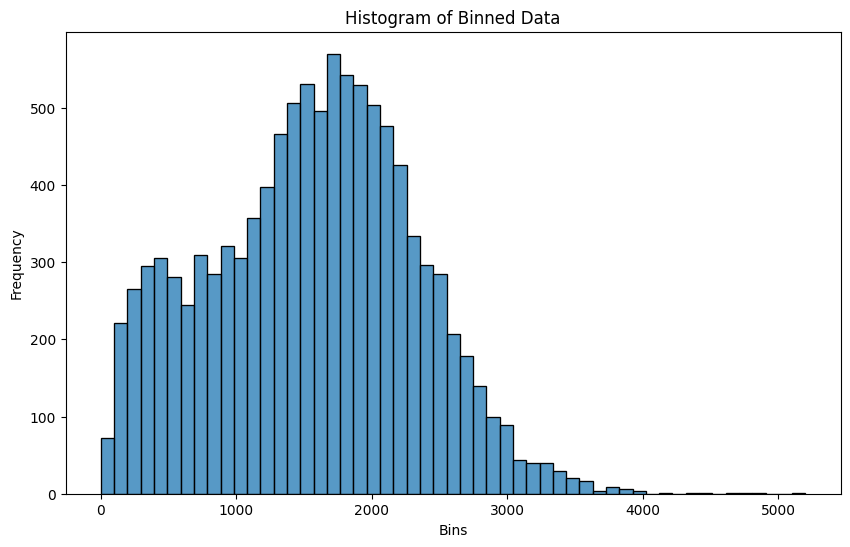

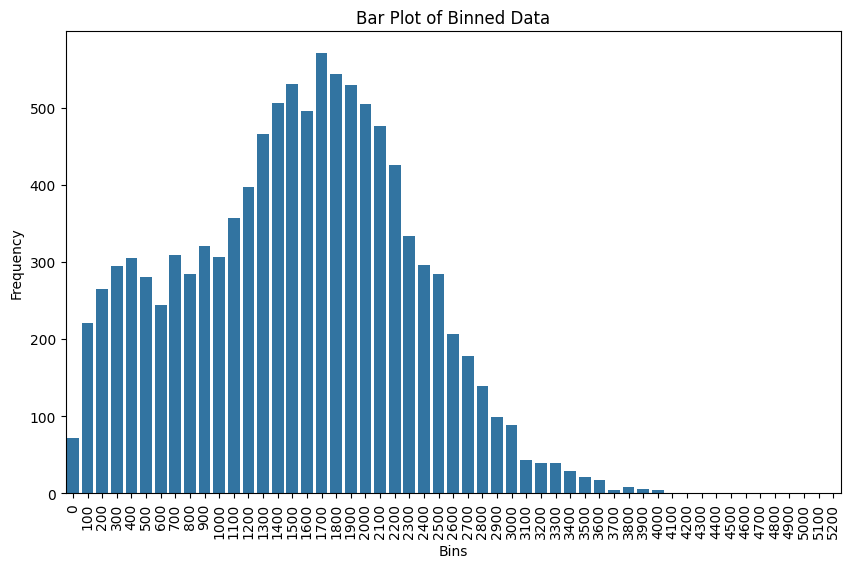

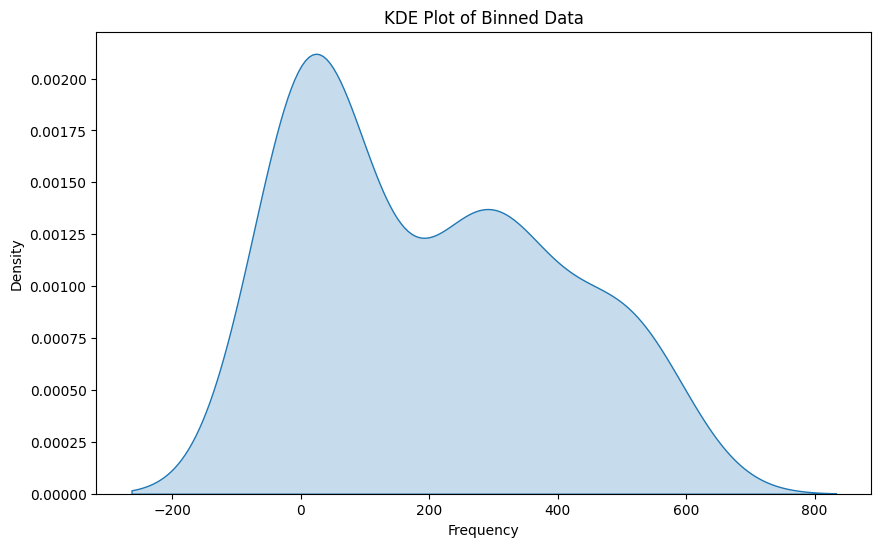

In [16]:
bins = list(discrete_distances.keys())
frequencies = list(discrete_distances.values())

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(x=bins, weights=frequencies, bins=len(bins), kde=False)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Binned Data')
plt.show()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=bins, y=frequencies)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Bar Plot of Binned Data')
plt.xticks(rotation=90)
plt.show()

# Create a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=frequencies, fill=True)
plt.xlabel('Frequency')
plt.title('KDE Plot of Binned Data')
plt.show()

In [17]:
goalkeepers = []
defenders = []
midfielders = []
forwards = []

In [18]:
for player in players_df.iterrows():
    if(player[1]['role']['code2'] == 'GK'):
        goalkeepers.append(player[1]['wyId'])
    elif(player[1]['role']['code2'] == 'DF'):
        defenders.append(player[1]['wyId'])
    elif(player[1]['role']['code2'] == 'MD'):
        midfielders.append(player[1]['wyId'])
    elif(player[1]['role']['code2'] == 'FW'):
        forwards.append(player[1]['wyId'])

In [19]:
distances_per_role = {'GK': [], 'DF': [], 'MD': [], 'FW': []}

In [20]:
for team in teams_distances:
    for player in teams_distances[team]:
        if player in goalkeepers:
            distances_per_role['GK'].append(teams_distances[team][player])
        elif player in defenders:
            distances_per_role['DF'].append(teams_distances[team][player])
        elif player in midfielders:
            distances_per_role['MD'].append(teams_distances[team][player])
        elif player in forwards:
            distances_per_role['FW'].append(teams_distances[team][player])